In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
import rasterio
from rasterio.transform import from_origin
from rasterio.plot import show


In [2]:
# Definir la función de velocidad terminal Vs(z)
def Vs(z):
    Vs_zmin = 0.05  # Velocidad de caída en zmin (m/s)
    return Vs_zmin * np.exp(0.024 * z)


# Tiempo total de la erupción en segundos (72 horas)
tiempo_total_erupcion = 72 * 3600  # 72 horas convertidas a segundos


# Definir la función de emisión acumulada de partículas para las 72 horas
def Q_acumulado(H, tiempo_total_erupcion):
    Q = (H / 0.117)**4.54  # Tasa de emisión basada en la fórmula de Settle
    return Q * tiempo_total_erupcion  # Tasa de emisión acumulada para 72 horas


# Definir el término fuente modificado con la tasa de emisión acumulada
def source_term(H, A, r0, x, y, z, t):
    Q_dynamic = Q_acumulado(H, tiempo_total_erupcion)  # Tasa de emisión acumulada
    f = 1 / (np.pi * (r0 + z / 8)**2)
    S = (A**2 * (1 - z / H) * np.exp(A * (z / H - 1))) / (H * (1 - (1 + A) * np.exp(-A)))
    return Q_dynamic * S * f


# Condiciones iniciales
def initial_condition(x, y, z):
    return tf.exp(-0.1 * (x**2 + y**2 + z**2))


# Definir la ecuación diferencial parcial de advección-difusión con término temporal
def advection_diffusion(c, x, y, z, t, u_x, u_y, u_z, D_xx, D_yy, D_zz, S):
    c_x, c_y, c_z = tf.gradients(c, [x, y, z])
    c_xx, c_yy, c_zz = tf.gradients(c_x, x)[0], tf.gradients(c_y, y)[0], tf.gradients(c_z, z)[0]
    c_t = tf.gradients(c, t)[0]
    Vs_value = Vs(z)
    return c_t + u_x * c_x + u_y * c_y + Vs_value * c_z - (D_xx * c_xx + D_yy * c_yy + D_zz * c_zz) - S


# Parámetros de la simulación (modificados según los datos reales del volcán Hudson 1991)
x = np.linspace(-10, 10, 50)  # Reducido a 50 puntos
y = np.linspace(-10, 10, 50)
z = np.linspace(-10, 10, 50)
t = np.linspace(0, 10, 50)  # Reducido a 50 puntos
X, Y, Z = np.meshgrid(x, y, z)
X_flatten, Y_flatten, Z_flatten = X.flatten(), Y.flatten(), Z.flatten()


# Parámetros actualizados
u_x, u_y, u_z = 4.1156, -3.6011, 0.2  # Velocidades del viento en m/s
D_xx, D_yy, D_zz = 4000, 4000, 45  # Coeficientes de difusión en m²/s (ajustados)
Vs_zmin = 0.05  # Velocidad terminal de caída en zmin en m/s
r0 = 400  # Radio del cráter en metros
H = 16.0  # Altura máxima de la columna en kilómetros
A = 1.5  # Parámetro adimensional para la posición de máxima concentración

In [3]:
# Datos de terreno reales
def terrain_data():
    # Datos de isopacas medidos en terreno
    distances = np.array([17841.24, 13819.76, 10555.02, 2110.04, 25231.325, 29586.351, 34549.414, 39088.20])  # En metros
    thickness = np.array([0.5, 1.0, 1.5, 0.4, 0.3, 0.2, 0.18, 0.15])  # Espesor de isopacas en metros


    # Asumimos que las coordenadas (X, Y) están en el plano y Z es la altura del terreno.
    # Vamos a generar datos radiales en el plano.
    theta = np.linspace(0, 2 * np.pi, len(distances))
    X_terrain = distances * np.cos(theta)
    Y_terrain = distances * np.sin(theta)
    Z_terrain = np.zeros_like(X_terrain)  # Asumimos que el terreno está plano en Z=0


    # Inputs de entrenamiento
    inputs_terreno = np.stack([X_terrain, Y_terrain, Z_terrain, np.zeros_like(X_terrain)], axis=-1)
    targets_terreno = thickness  # Los valores de isopacas como objetivo
    return inputs_terreno, targets_terreno


In [4]:
# Combinar datos de entrenamiento originales y datos de terreno
T_flatten = np.full(X_flatten.shape, 0)  # Tiempo inicial para las condiciones iniciales
inputs_sinteticos = np.stack([X_flatten, Y_flatten, Z_flatten, T_flatten], axis=-1)
targets_sinteticos = initial_condition(X_flatten, Y_flatten, Z_flatten).numpy()


# Datos de terreno
inputs_terreno, targets_terreno = terrain_data()


# Combinar ambos conjuntos de datos
inputs_combinados = np.vstack([inputs_sinteticos, inputs_terreno])
targets_combinados = np.concatenate([targets_sinteticos.flatten(), targets_terreno])

In [5]:
# Ajuste de la función de pérdida personalizada
def custom_loss(y_true, y_pred):
    initial_condition_penalty = tf.reduce_mean(tf.square(y_pred - y_true))
    return 0.1 * initial_condition_penalty + tf.keras.losses.MeanSquaredError()(y_true, y_pred)


# Modelo de red neuronal con softplus para concentraciones positivas
model = models.Sequential([
    layers.Dense(50, activation='tanh', input_shape=(4,)),
    layers.Dense(50, activation='tanh'),
    layers.Dense(50, activation='tanh'),  # Capa adicional
    layers.Dense(1, activation='softplus')  # Softplus para evitar concentraciones negativas
])


# Compilar el modelo
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=custom_loss)


c:\Users\djara\Documents\ML-team\.venv\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Entrenamiento de la red neuronal con más épocas
model.fit(inputs_combinados, targets_combinados, epochs=500, verbose=1, batch_size=256)


Epoch 1/500
489/489 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0432
Epoch 2/500
489/489 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080
Epoch 3/500
489/489 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0080
Epoch 4/500
489/489 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0079
Epoch 5/500
489/489 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0074
Epoch 6/500
489/489 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0045
Epoch 7/500
489/489 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0010
Epoch 8/500
489/489 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6825e-04
Epoch 9/500
489/489 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.3367e-04
Epoch 10/500
489/489 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.4938e-05
Epoch 11/500
489/489 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.4347e-04
Epoch 12/500
489/489 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.5049e-05
Epoch 13/500
489/489 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.8692e-05
Epoch 14/500
489/489 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.7727e-05
Epoch 15/500
48

3907/3907 ━━━━━━━━━━━━━━━━━━━━ 2s 552us/step
Archivo GeoTIFF 'prediccion_t0.tif' exportado correctamente.
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 2s 578us/step
Archivo GeoTIFF 'prediccion_t10.tif' exportado correctamente.
Predicciones exportadas y resultados guardados correctamente.
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 2s 555us/step
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 2s 558us/step
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 2s 558us/step
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 2s 580us/step
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 2s 562us/step
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 2s 563us/step


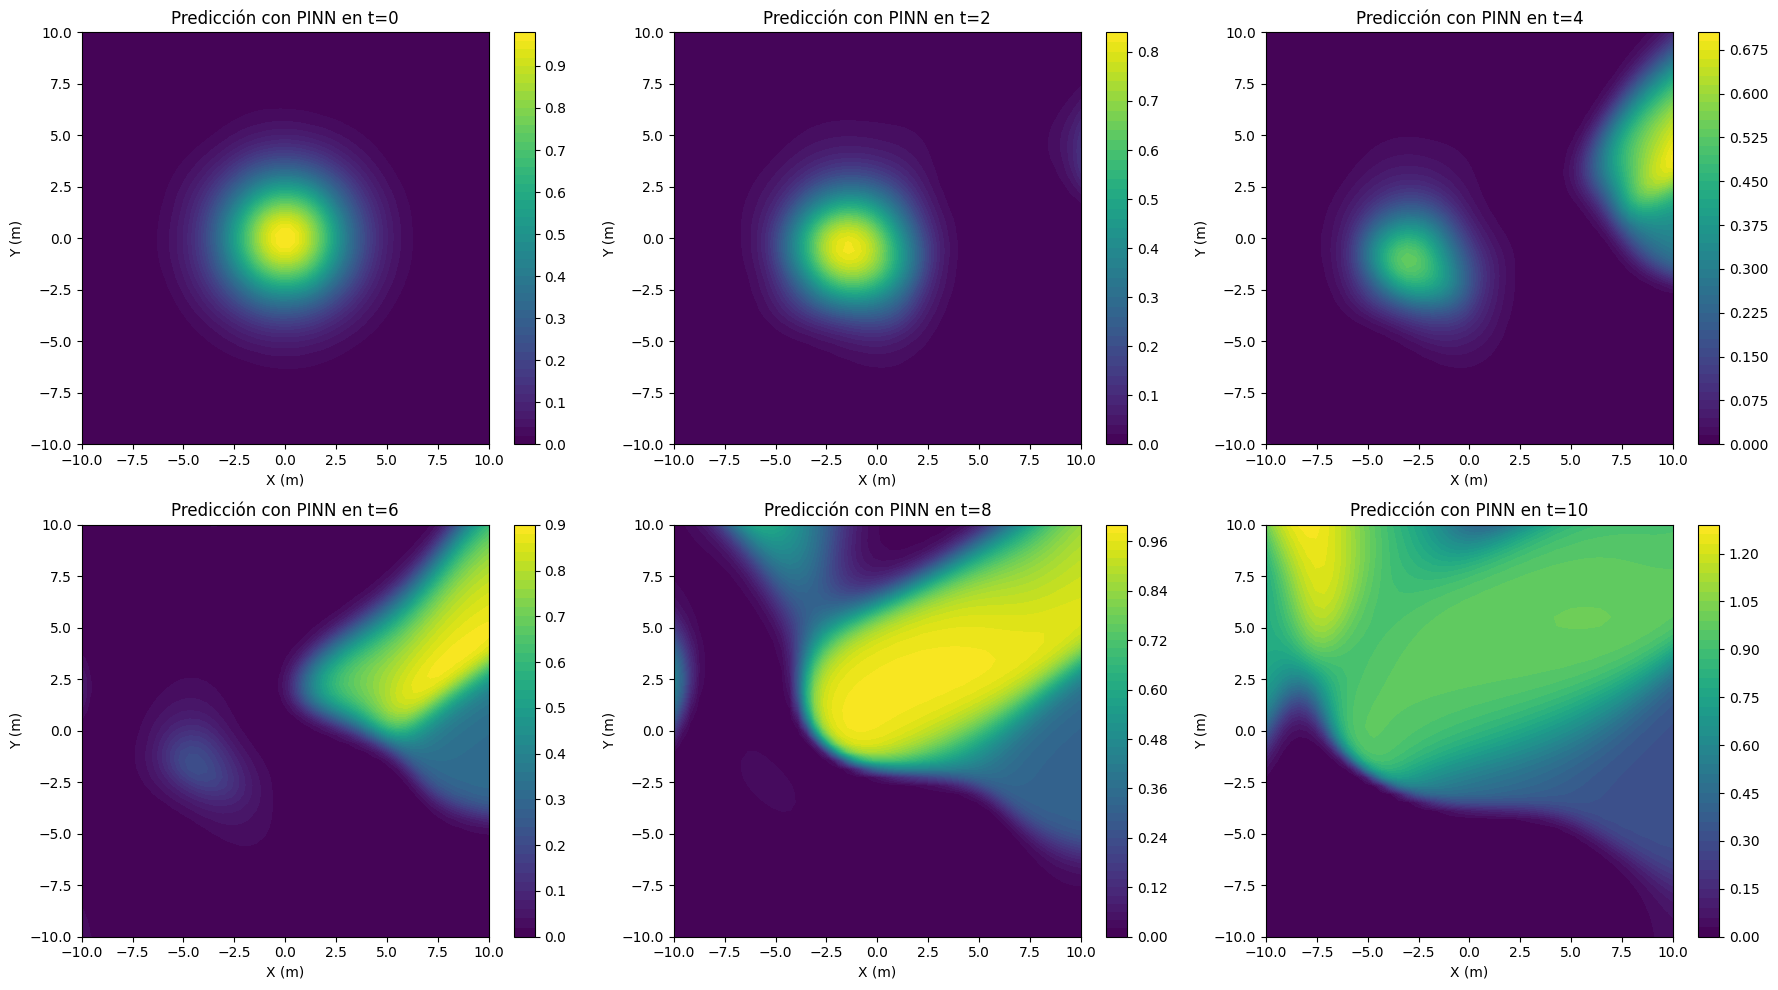

3907/3907 ━━━━━━━━━━━━━━━━━━━━ 2s 556us/step
Archivo GeoTIFF 'prediccion_t0.tif' exportado correctamente.
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 2s 611us/step
Archivo GeoTIFF 'prediccion_t2.tif' exportado correctamente.
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 2s 555us/step
Archivo GeoTIFF 'prediccion_t4.tif' exportado correctamente.
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 2s 559us/step
Archivo GeoTIFF 'prediccion_t6.tif' exportado correctamente.
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 2s 557us/step
Archivo GeoTIFF 'prediccion_t8.tif' exportado correctamente.
3907/3907 ━━━━━━━━━━━━━━━━━━━━ 2s 585us/step
Archivo GeoTIFF 'prediccion_t10.tif' exportado correctamente.


In [7]:
# Definir la función export_to_geotiff para guardar predicciones como archivo GeoTIFF
def export_to_geotiff(data, filename, transform):
    with rasterio.open(
        filename, 'w',
        driver='GTiff',
        height=data.shape[0],
        width=data.shape[1],
        count=1,
        dtype=data.dtype,
        crs='EPSG:32718',  # Proyección UTM Zona 18S
        transform=transform
    ) as dst:
        dst.write(data, 1)


# Transformación geoespacial (ajustar a la región del volcán Hudson)
x_min, y_max = 640000, 4810000  # Coordenadas UTM del área del Volcán Hudson (aproximadas)
pixel_size = 100  # Tamaño del píxel en metros


# Crear la transformación desde el origen
transform = from_origin(x_min, y_max, pixel_size, pixel_size)


# Predicción y exportación de resultados en formato GeoTIFF
for time in [0, 10]:  # Puedes ajustar los tiempos según lo necesites
    prediction = model.predict(np.stack([X_flatten, Y_flatten, Z_flatten, np.full(X_flatten.shape, time)], axis=-1)).reshape(50, 50, 50)
    output_filename = f"prediccion_t{time}.tif"
    export_to_geotiff(prediction[:, :, 25], output_filename, transform)
    print(f"Archivo GeoTIFF '{output_filename}' exportado correctamente.")


# Guardar los resultados de entrenamiento en archivos CSV o Excel si es necesario
r = np.sqrt(X_flatten**2 + Y_flatten**2 + Z_flatten**2)
df = pd.DataFrame({'Distancia': r, 'Concentración': prediction.flatten()})
df.to_csv('concentracion_vs_distancia.csv', index=False)
df.to_excel('concentracion_vs_distancia.xlsx', index=False)
print("Predicciones exportadas y resultados guardados correctamente.")


# Predicción con la red entrenada en diferentes momentos
times_to_predict = [0, 2, 4, 6, 8, 10]  # Diferentes tiempos para predecir
fig, axs = plt.subplots(2, 3, figsize=(18, 10))


for i, time in enumerate(times_to_predict):
    inputs_time = np.stack([X_flatten, Y_flatten, Z_flatten, np.full(X_flatten.shape, time)], axis=-1)
    predictions = model.predict(inputs_time).reshape((50, 50, 50))


    ax = axs.flatten()[i]
    ax.contourf(X[:, :, 25], Y[:, :, 25], predictions[:, :, 25], levels=50, cmap='viridis')
    ax.set_title(f'Predicción con PINN en t={time}')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    plt.colorbar(ax.contourf(X[:, :, 25], Y[:, :, 25], predictions[:, :, 25], levels=50, cmap='viridis'), ax=ax)


plt.tight_layout()
plt.show()


# Exportar predicciones de diferentes tiempos
for time in times_to_predict:
    prediction = model.predict(np.stack([X_flatten, Y_flatten, Z_flatten, np.full(X_flatten.shape, time)], axis=-1)).reshape(50, 50, 50)
    output_filename = f"prediccion_t{time}.tif"
    export_to_geotiff(prediction[:, :, 25], output_filename, transform)
    print(f"Archivo GeoTIFF '{output_filename}' exportado correctamente.")


# Guardar resultados en CSV
r = np.sqrt(X_flatten**2 + Y_flatten**2 + Z_flatten**2)
df = pd.DataFrame({'Distancia': r, 'Concentración': predictions.flatten()})
df.to_csv('concentracion_vs_distancia.csv', index=False)


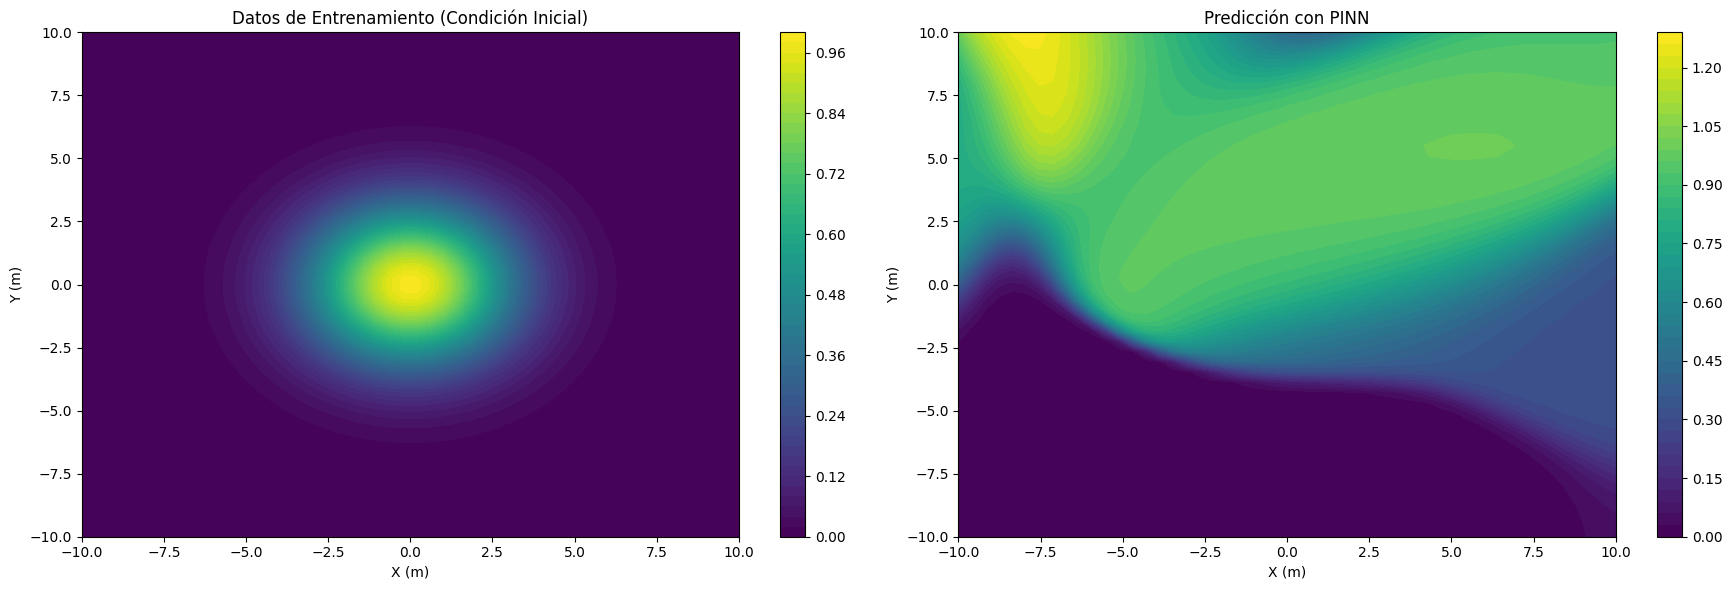

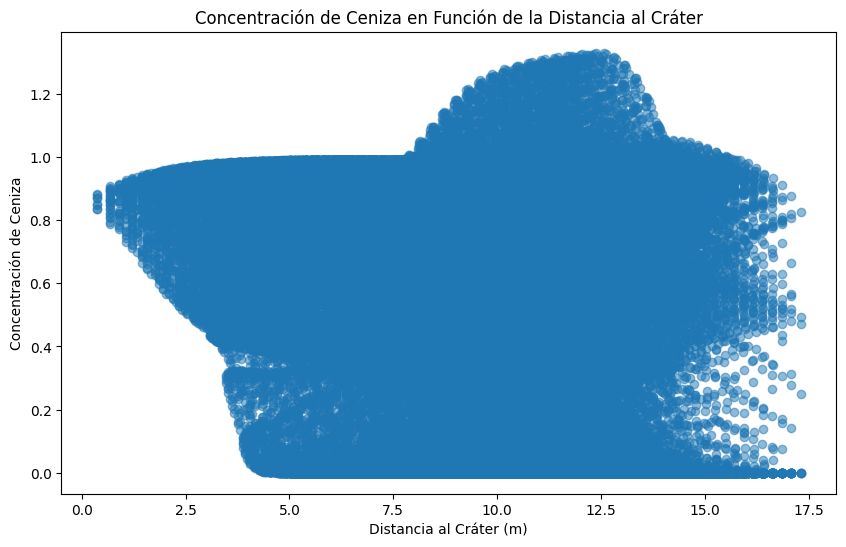

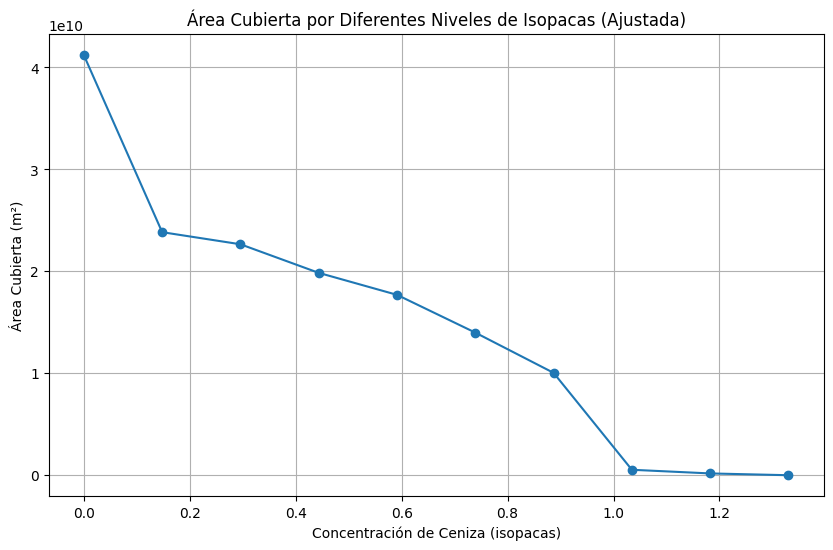

In [9]:
# Gráfico de datos de entrenamiento con la misma escala de color
plt.figure(figsize=(18, 6))


plt.subplot(1, 2, 1)
cont1 = plt.contourf(X[:, :, 25], Y[:, :, 25], targets_sinteticos.reshape(50, 50, 50)[:, :, 25], levels=50, cmap='viridis')
plt.colorbar(cont1)
plt.title('Datos de Entrenamiento (Condición Inicial)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')


# Gráfico de predicción con PINN con la misma escala de color
plt.subplot(1, 2, 2)
cont2 = plt.contourf(X[:, :, 25], Y[:, :, 25], predictions[:, :, 25], levels=50, cmap='viridis')
plt.colorbar(cont2)
plt.title('Predicción con PINN')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')


plt.tight_layout()
plt.show()


# Calcular la distancia radial al cráter
r = np.sqrt(X_flatten**2 + Y_flatten**2 + Z_flatten**2)


# Guardar los resultados en un archivo .csv en el directorio actual
df = pd.DataFrame({'Distancia': r, 'Concentración': predictions.flatten()})
df.to_csv('concentracion_vs_distancia.csv', index=False)


# Gráfico adicional: Concentración vs Distancia
plt.figure(figsize=(10, 6))
plt.scatter(r, predictions.flatten(), alpha=0.5)
plt.xlabel('Distancia al Cráter (m)')
plt.ylabel('Concentración de Ceniza')
plt.title('Concentración de Ceniza en Función de la Distancia al Cráter')
plt.show()


# Calcular el área bajo la curva para diferentes valores de concentración (isopacas)
isopacas = np.linspace(predictions.min(), predictions.max(), num=10)  # Dividir en 10 niveles
areas = []


for iso in isopacas:
    # Calcular el área donde la concentración es mayor que el nivel de isopaca
    area = np.sum(predictions >= iso) * (x[1] - x[0]) * (y[1] - y[0])  # Aproximar el área
    areas.append(area)


# Ajuste del área total basado en la estimación conocida de 150,000 km²
total_area = 150000 * 1e6  # 150,000 km² a m²
areas_normalizadas = [area / np.sum(areas) * total_area for area in areas]


# Graficar el área versus isopacas ajustadas
plt.figure(figsize=(10, 6))
plt.plot(isopacas, areas_normalizadas, marker='o')
plt.xlabel('Concentración de Ceniza (isopacas)')
plt.ylabel('Área Cubierta (m²)')
plt.title('Área Cubierta por Diferentes Niveles de Isopacas (Ajustada)')
plt.grid(True)
plt.show()
